# **Avance 2. Series de tiempo univariadas:**
## **Universidad Nacional de Colombia.**
## **Docente:**

  - [Sergio Alejandro Calderón Villanueva](sacalderonv@unal.edu.co)

## **Autores:**

  - [Michel Mendivenson Barragán Zabala](mbarraganz@unal.edu.co)
  - [Sharon Juliana Zambrano Ortiz](shzambranoo@unal.edu.co)
  - [Nicolás Alejandro Quenguan Parra](naquenguanp@unal.edu.co)
  - [Aryin Jair Torres Quiñone](artorresq@unal.edu.co)

---
**Nota 1:** Los avances estaban siendo realizados en archivos de Rmarkdown `.Rmd`. Sin embargo, como la intención de este avance es incluir algunos modelos de aprendizaje profundo (Redes neuronales multicapa y redes recurrentes) con el fin de no utilizar recursos de computo de los equipos de cada uno de los autores se entregará el avance 2 como un archivo de jupyter notebook `.ipynb` que además de permitir el uso de computación en la nube para tareas pesadas usando Google Collab cuando los recursos de forma local sean reducidos también (Por ser `python`) permite construir chunks que usen código de `R` y `python` cuyos objetos tienen la posibilidad de interactuar entre sí (Veáse: [R and Python in one Jupyter notebook](https://stackoverflow.com/questions/39008069/r-and-python-in-one-jupyter-notebook))

**Nota 2:** Si se está editando este documento desde Google Collab, no es posible hacer `commit` directamente al repositorio. En cambio, hay que dar en la opción `File > Save a copy in GitHub`.

---

El siguiente código habilita el uso de código de `R` y `python` en simultáneo (Es neceasario el paquete `rpy2`):

In [718]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


**Cargando los paquetes necesarios de `R` y `python`:**

Además, es posible que se tenga que correr la siguiente línea si se está trabajando en **Google Collab** pues el paquete `skforecast`no se encuentra instalado de forma previa:

In [721]:
# !pip install skforecast

In [814]:
# Para los árboles de decisión
from sklearn.tree import DecisionTreeRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pylab as plt
from sklearn import tree

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [719]:
%%R
install.packages('latex2exp')
install.packages('astsa')

(as ‘lib’ is unspecified)







	‘/tmp/RtmpBZ73W9/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpBZ73W9/downloaded_packages’



Ahora se cargan los datos usando `R` y se exporta el objeto a `python`:

In [722]:
%%R -o leche
leche = read.csv("https://raw.githubusercontent.com/Mendivenson/Series-de-tiempo/main/Datos/Volumen%20de%20Acopio%20Total%20%20(2008%20-%202023).csv")
leche = leche[, c('Periodo', 'NACIONAL')]

Cualquier chunk de código que inicie con `%%R` será código `R` por lo que el siguiente código es 100% `python`:

In [723]:
leche

,Periodo,NACIONAL
1,Jan-08,2.458355e+08
2,Feb-08,2.130557e+08
3,Mar-08,2.175541e+08
4,Apr-08,2.224843e+08
5,May-08,2.386657e+08
...,...,...
188,Aug-23,2.979559e+08
189,Sep-23,2.845475e+08
190,Oct-23,2.876751e+08
191,Nov-23,2.809905e+08


En este avance se podrán encontrar tres cosas importantes para cada una de las series:

- Implementaciones de un filtro exponencial (`R`)
- Implementaciones de árboles de decisión binarios (`python`)
- Entrenamiento de redes neuronales multicapa (`python`)
- Entrenamiento de redes neuronales concurrentes (`python`)

---

# **Filtro exponencial**

---

:00 Esperando :v

## ¿por qué no funciona? xd

---

# **Árboles de decisión**

---

Los árboles de decisión se generan usando los rezagos de distinto orden de la serie como información adicional utilizada para predecir el valor que la serie tendrá en el tiempo $t + n$ siendo n un número de pasos escogido previamente. Es un método de sencilla implementación, sin embargo, no es muy potente cuando se tienen series con tendencia.

**Nota:** Es prudente revisar si la varianza es estable. Sin embargo, al hacer la transformación de boxcox en la serie de leche mensual no se observan cambios importantes en la estructura de la serie por lo que se decide usar en cambio la serie original.


## **Acopio nacional de leche (mensual)** 🐮


Como se observo en el [Avance 1](https://rpubs.com/Mendivenson/Avance1_STdU) la serie del volumen de acopio nacional es una serie con tendencia positiva por lo que será necesario eliminarla esta tendencia para poder continuar con la construcción del árbol. Más adelante, se mostrará la diferencia del método de árboles de decisión para la serie sin tendencia y para la serie con tendencia.

### **Eliminación de la tendencia**

De nuevo, similarmente a lo revisado en [Avance 1](https://rpubs.com/Mendivenson/Avance1_STdU), se escoge el método de suavizamiento kernel para eliminar la tendencia de la serie:

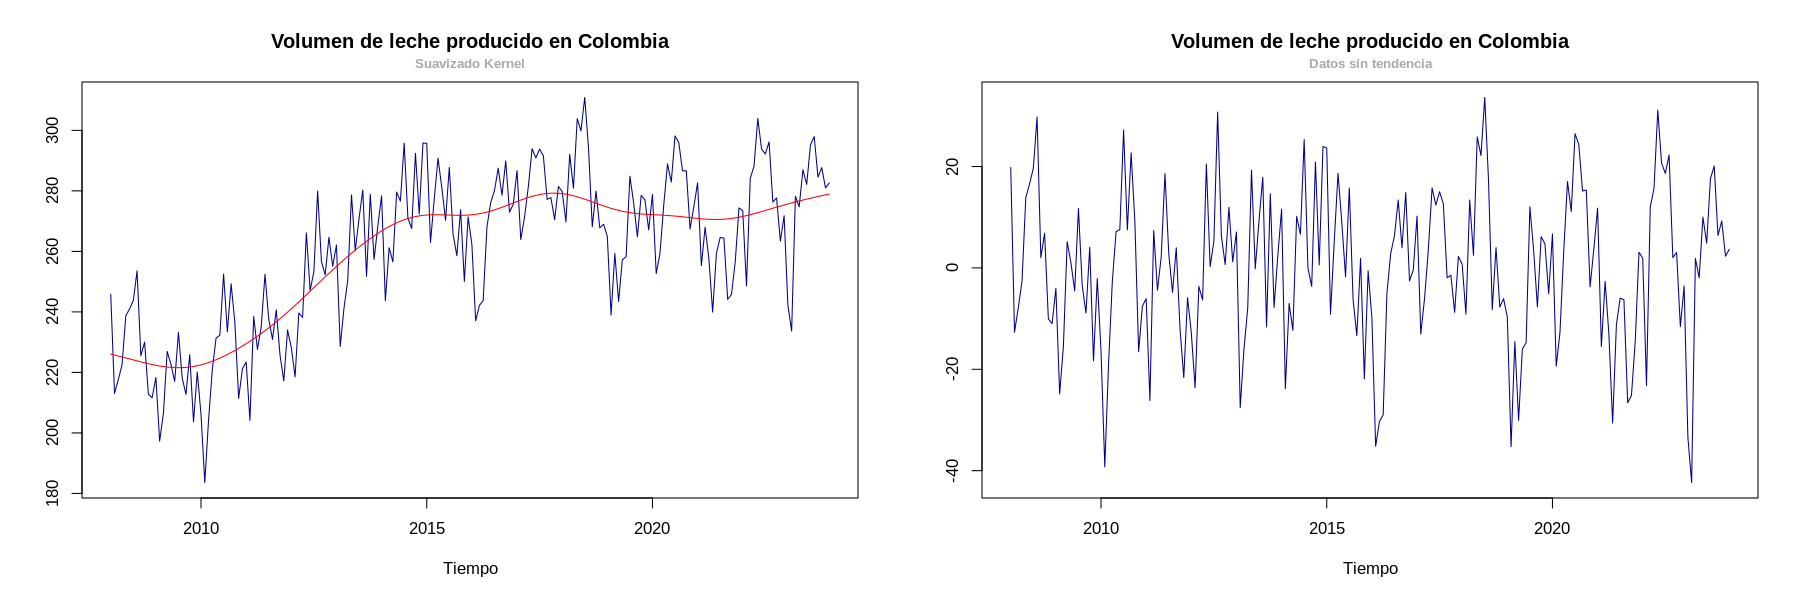

In [724]:
%%R -o leche -w 18 -h 6 --units in -r 100
leche$NACIONAL = leche$NACIONAL/1000000 # Los datos a partir de ahora estarán en millones de litros
lecheTend = leche

tiempo = seq(2008, 2023.95, by = 1/12)
predicciones = ksmooth(y = leche$NACIONAL, x = tiempo, kernel = 'normal', bandwidth = 2.5)$y

# Gráfico
par(mfrow = c(1,2))

# Original y suavizamiento kernel
plot(x = tiempo ,y = leche$NACIONAL, xlab = 'Tiempo', ylab = '', main = 'Volumen de leche producido en Colombia',col = 'darkblue', cex = 0.5, type = 'l')
mtext(bquote(bold('Suavizado Kernel')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')
lines(x = tiempo,y = predicciones, col = 'red')

# Datos sin tendencia
plot(x = tiempo,y = leche$NACIONAL - predicciones,xlab = 'Tiempo', ylab = '', main = 'Volumen de leche producido en Colombia',col = 'darkblue', cex = 0.5, type = 'l')
mtext(bquote(bold('Datos sin tendencia')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

# Actualizando el dataframe para devolverlo a python:
leche$NACIONAL = leche$NACIONAL - predicciones

In [725]:
%%R -o lecheTend
''

[1] ""


### **Selección de rezagos**

Una vez realizada la eliminación de la tendencia, es preciso escoger los rezagos que parecen estar más relacionados con el valor actual de la serie de los demás para incluirlos como covariables en nuestro árbol. Para hacer esto, podemos ayudarnos de un periodograma y algunos gráficos descriptivos también ya realizados en el [Avance 1](https://rpubs.com/Mendivenson/Avance1_STdU):

#### **Autocorrelación y autocorrelación parcial:**

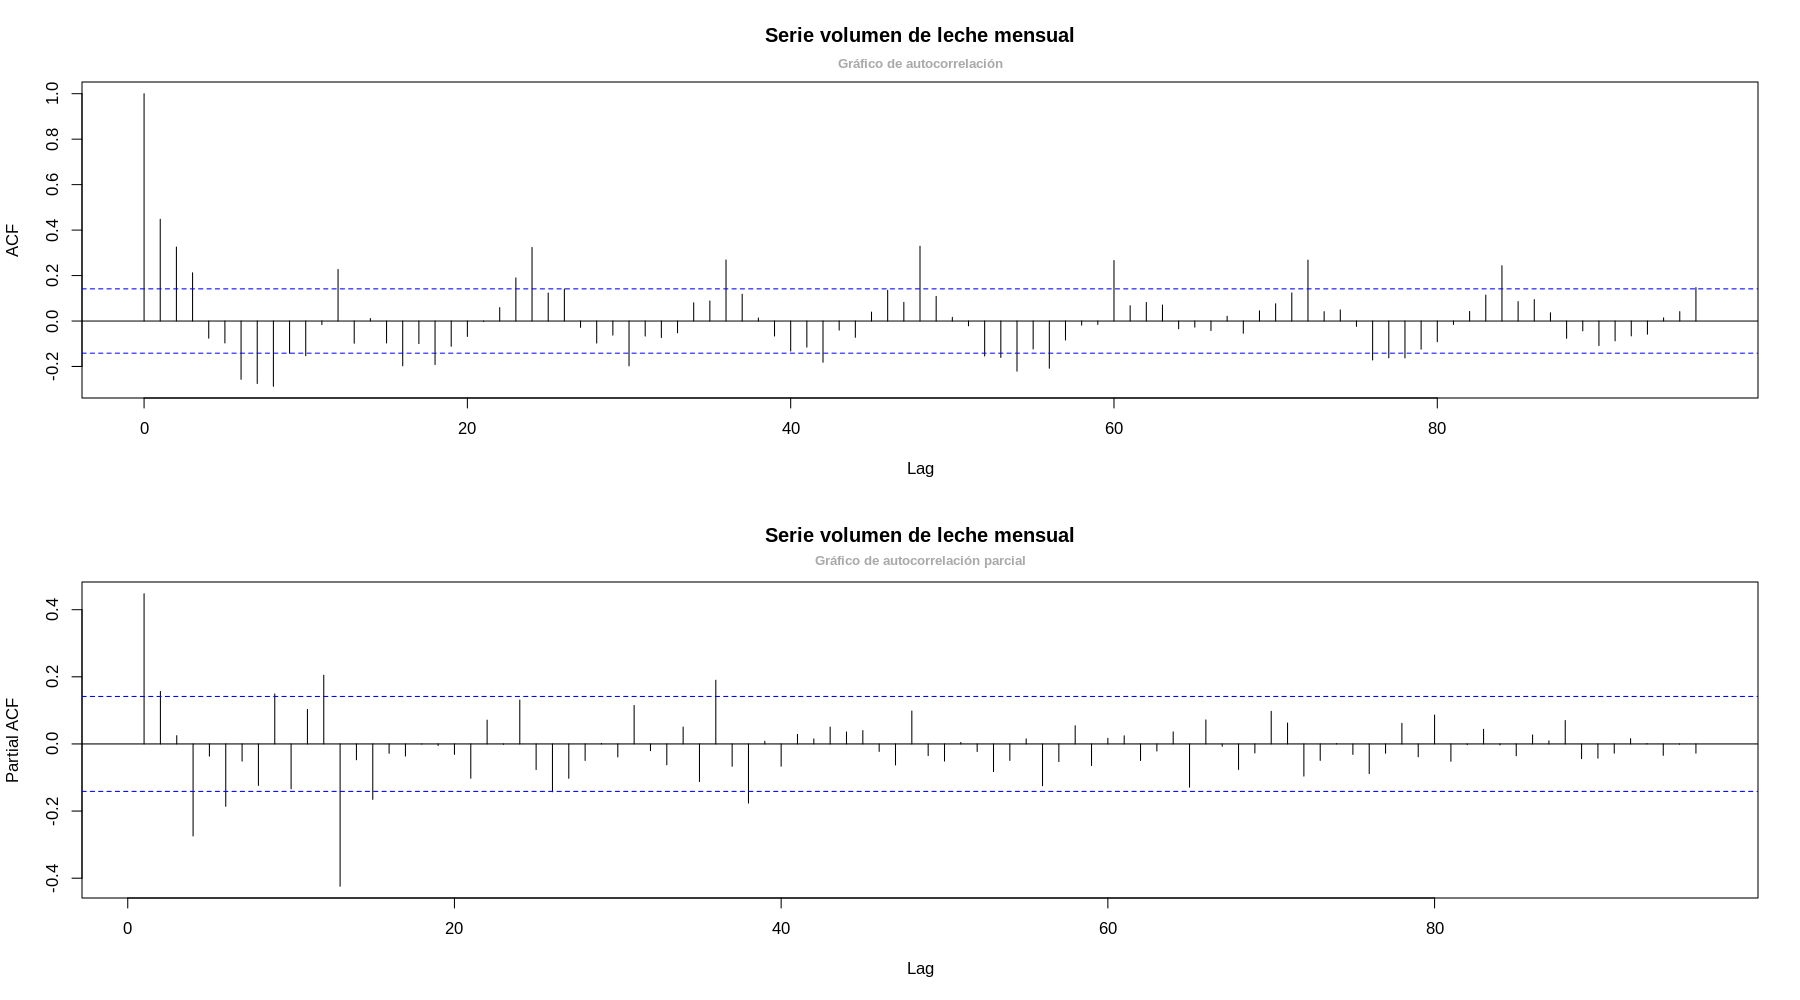

In [726]:
%%R -w 18 -h 10 --units in -r 100
par(mfrow = c(2,1))

# Autocorrelación
acf(leche$NACIONAL, lag.max = 96, main = 'Serie volumen de leche mensual')
mtext(bquote(bold('Gráfico de autocorrelación')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

# Autocorrelación parcial
pacf(leche$NACIONAL, lag.max = 96, main = 'Serie volumen de leche mensual')
mtext(bquote(bold('Gráfico de autocorrelación parcial')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

La autocorrelación y autocorrelación parcial sugieren patrones anuales. Revisemos la serie más a fondo.

#### **Boxplot mensual y subseries**

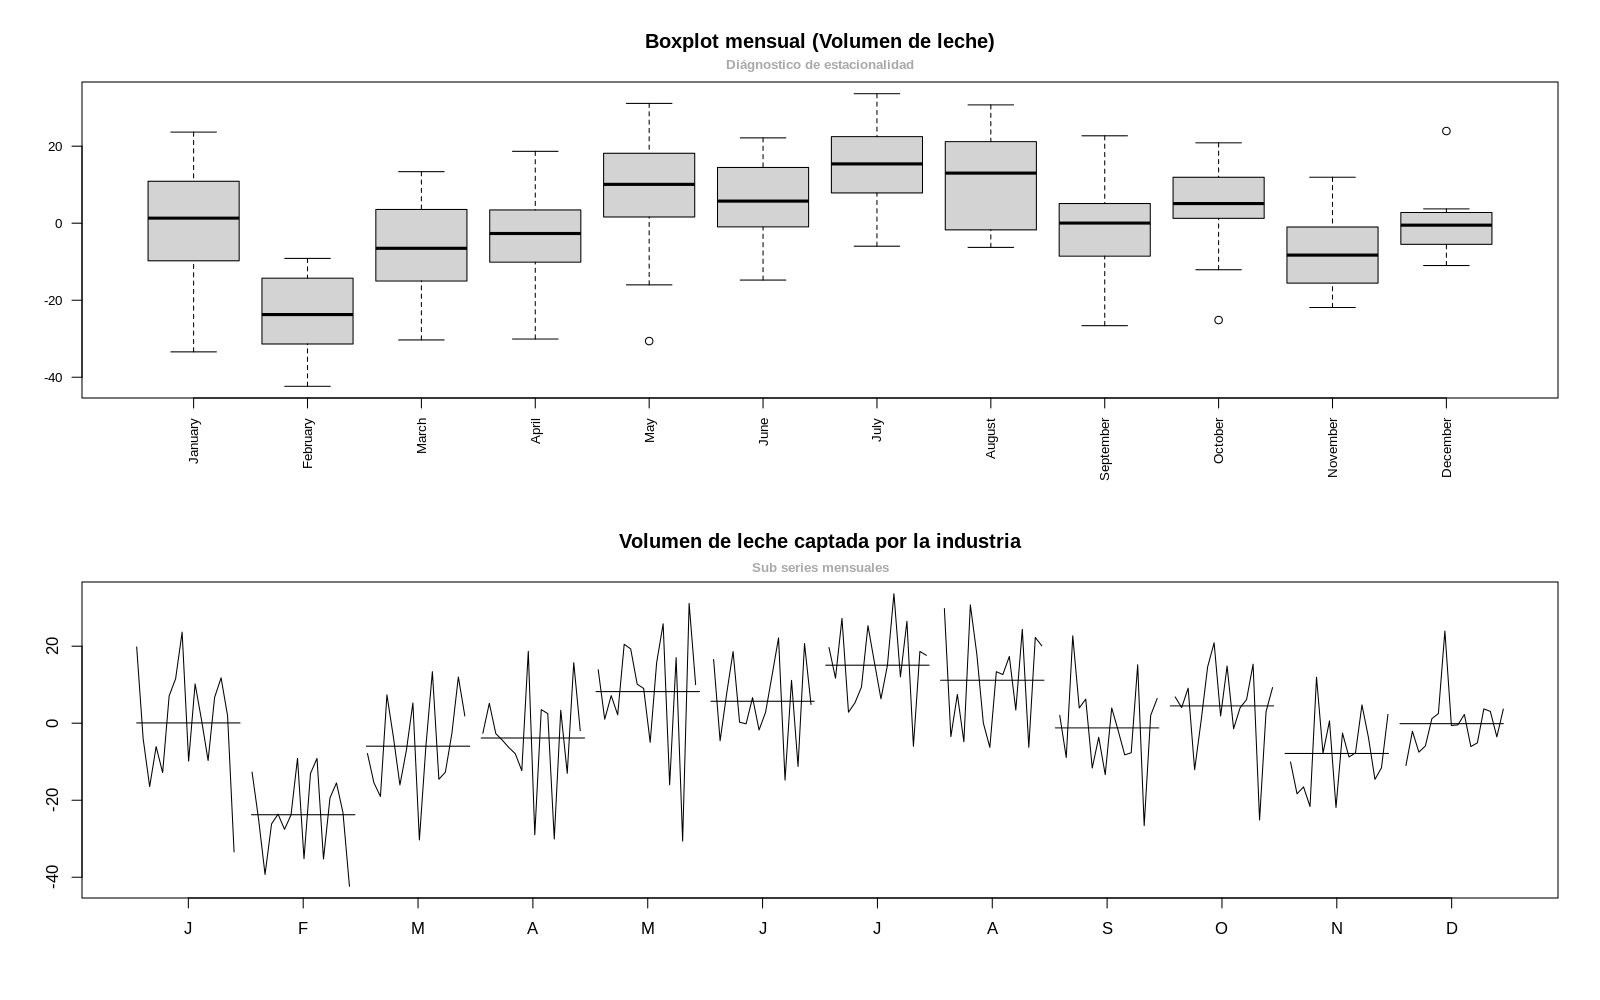

In [727]:
%%R -w 16 -h 10 --units in -r 100
colnames(leche) = c('Date', 'Volume')
months = 1:nrow(leche) %% 12
months[months == 0] = 12
leche$Month = month.name[months]

lechePorMeses = data.frame(row.names = month.name[1:12])
for (i in month.name[1:12]){
    lechePorMeses[i,1:16] = leche$Volume[leche$Month == i]
}

lechePorMeses = t(lechePorMeses)
rownames(lechePorMeses) = 2008:2023

par(mfrow = c(2,1))

# Gráfico de boxplot por meses
boxplot(lechePorMeses,las = 2, cex.axis = 0.8, main = 'Boxplot mensual (Volumen de leche)')
mtext(bquote(bold('Diágnostico de estacionalidad')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')

# sub series mensuales
monthplot(ts(leche$Volume, start = 2008, frequency = 12), ylab = '', main = 'Volumen de leche captada por la industria')
mtext(bquote(bold('Sub series mensuales')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')


Nuevamente, es claro que existe algún tipo de estacionalidad ligada al mes en que se mide la serie debido a que se presentan distintas medias para cada sub serie mensual.

#### **Periodograma**

Finalmente, revisemos el periodograma para verificar que, además de la estacionalidad anual, no existan estacionalidades con otros períodos:

		 ---- LOS PRIMEROS TRES VALORES MÁXIMOS ----  

-	El valor máximo no. 1  en el que se máximiza el periodograma es 4488.692 en la frecuencia  0.08333333 
 	o lo que es equivalente a  1 años 
-	El valor máximo no. 2  en el que se máximiza el periodograma es 1798.497 en la frecuencia  0.04166667 
 	o lo que es equivalente a  0.5 años 
-	El valor máximo no. 3  en el que se máximiza el periodograma es 1420.426 en la frecuencia  0.4166667 
 	o lo que es equivalente a  5 años 






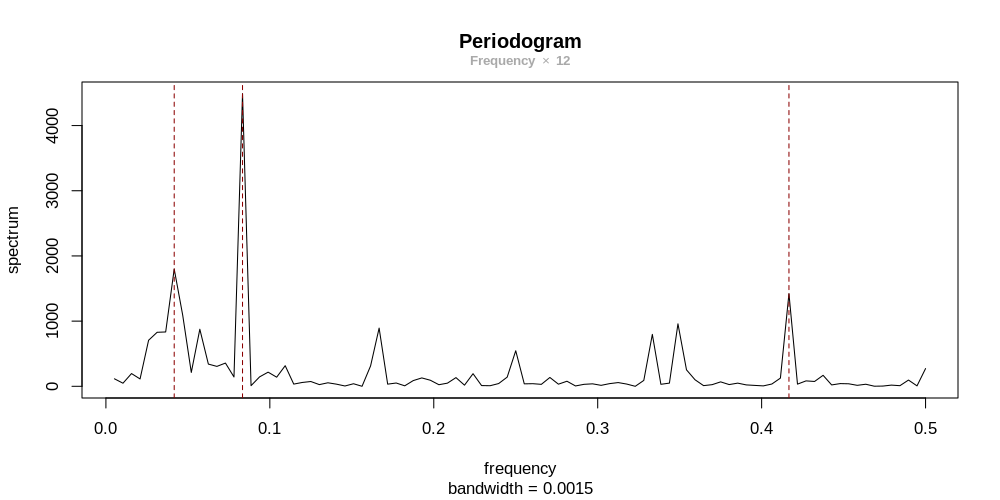

In [728]:
%%R -w 10 -h 5 --units in -r 100
library(latex2exp)
PeriodogramaLeche = spectrum(leche$Volume, log = 'no', main = 'Periodogram')
mtext(TeX('Frequency $\\times$ 12', bold = T),
      side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

Periodograma = PeriodogramaLeche$spec
frecuencias = PeriodogramaLeche$freq

cat('\t\t ---- LOS PRIMEROS TRES VALORES MÁXIMOS ---- ', end = '\n\n')
for (i in 1:3){
  ind = which.max(Periodograma)
  cat('-\tEl valor máximo no.', i, ' en el que se máximiza el periodograma es', Periodograma[ind], 'en la frecuencia ',
      frecuencias[ind],'\n \to lo que es equivalente a ',   frecuencias[ind] * 12 , 'años', end = '\n')
  abline(v = frecuencias[ind], col = 'darkred', lty = 2)
  Periodograma = Periodograma[-ind]
  frecuencias = frecuencias[-ind]
}

cat('\n\n\n\n')

Por lo que tal vez, sería pudente incluir los rezagos 6 y 12 en nuestro árbol de decisión. Por otro lado, a pesar de que no es importante realizar un reconocimiento funcional de las relaciones entre los rezagos para la construcción de un árbol de decisión de todas formas se muestra a continuación un gráfico de retardos:

#### **Gráfico de retardos**

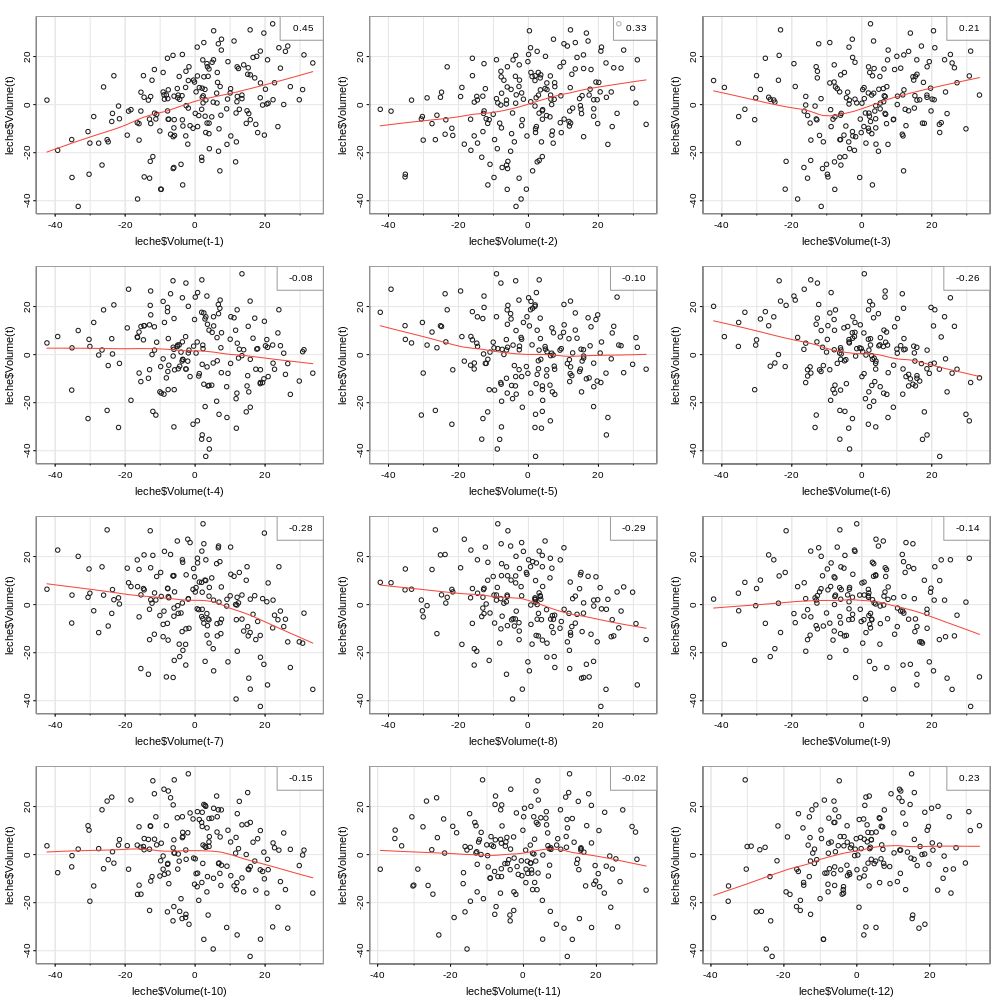

In [729]:
%%R -w 10 -h 10 --units in -r 100
astsa::lag1.plot(leche$Volume, 12,corr = T)

In [733]:
%%R -o leche
año = 2008
for(i in 1:nrow(leche)){
    month = i %% 12
    if (month == 0){month = 12}
    if (month < 10){month = paste0('0', month)}
    leche$Date[i] = paste0(año,'-', month,'-01')
    if(month == 12){año = año + 1}
}

leche = leche[,c('Date', 'Volume')]

In [734]:
leche

,Date,Volume
1,2008-01-01,19.795864
2,2008-02-01,-12.682066
3,2008-03-01,-7.872412
4,2008-04-01,-2.623688
5,2008-05-01,13.881874
...,...,...
188,2023-08-01,20.100389
189,2023-09-01,6.408911
190,2023-10-01,9.259564
191,2023-11-01,2.303314


### **Separando los datos entre datos de entrenamiento y prueba**

Debido a la cantidad de datos presentes en la serie (192) se realizará la selección de los hiper paramétros mediante validación cruzada independientemente del árbol y rezagos que se utilicen. Además, se usará el conjunto de mediciones del último año de la serie (2023) para medir la capacidad predictiva del árbol:


In [ ]:
leche['Date'] = pd.to_datetime(leche['Date'])
leche = leche.set_index('Date')
leche = leche.asfreq('MS')
leche

In [795]:
trainLeche = leche['Volume'][0:-12]
testLeche = leche['Volume'][-12:len(leche)]
print(trainLeche)
print(testLeche)

Date
2008-01-01    19.795864
2008-02-01   -12.682066
2008-03-01    -7.872412
2008-04-01    -2.623688
2008-05-01    13.881874
                ...    
2022-08-01    22.273918
2022-09-01     2.036131
2022-10-01     3.040229
2022-11-01   -11.597113
2022-12-01    -3.549744
Freq: MS, Name: Volume, Length: 180, dtype: float64
Date
2023-01-01   -33.413477
2023-02-01   -42.349878
2023-03-01     1.871824
2023-04-01    -1.942573
2023-05-01    10.025542
2023-06-01     4.868121
2023-07-01    17.619143
2023-08-01    20.100389
2023-09-01     6.408911
2023-10-01     9.259564
2023-11-01     2.303314
2023-12-01     3.667490
Freq: MS, Name: Volume, dtype: float64


Es decir, nuestro conjunto de datos queda separado de la siguiente forma:

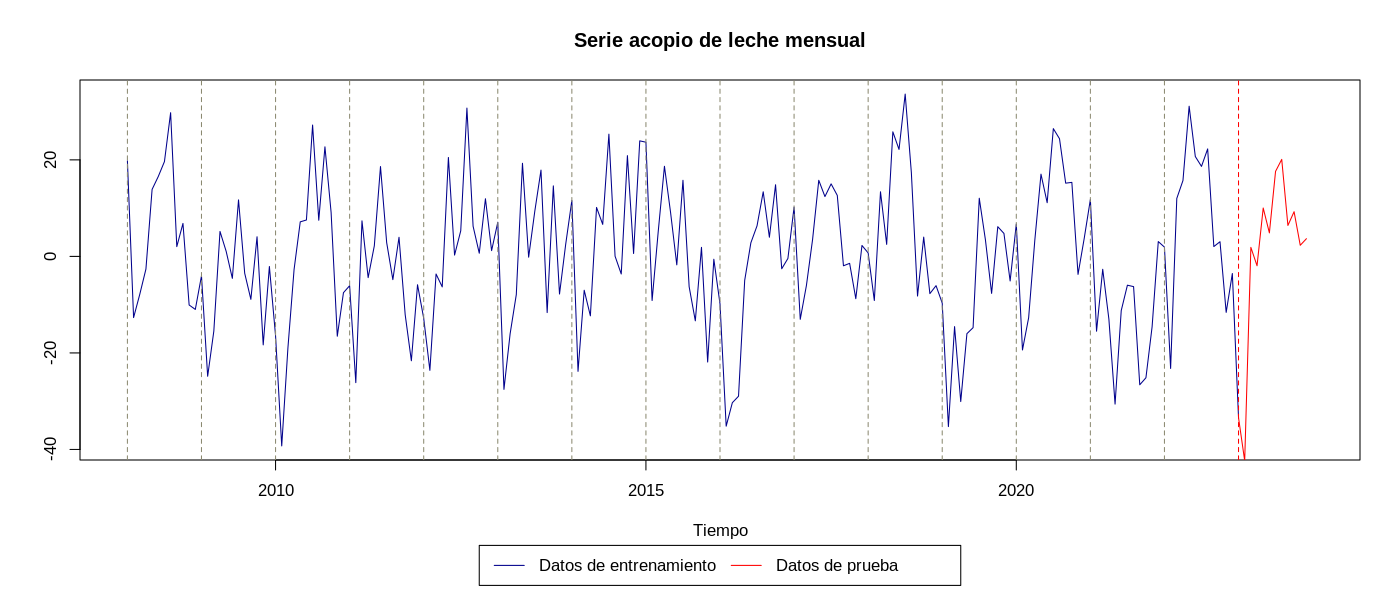

In [633]:
%%R -w 14 -h 6 --units in -r 100
par(mar = c(7,4,4,2))
plot(x = seq(2008, 2023, by= 1/12), y = head(leche$Volume, n = nrow(leche)-11), type = 'l',
     main = 'Serie acopio de leche mensual', ylab = '', xlab = 'Tiempo', col = 'darkblue', xlim = c(2008,2024))
abline(v = 2008:2023, lty = 'dashed', pch = 2,col = c(rep('#8B8970', 15), 'red'))
lines(x = seq(2023, 2023.99, by = 1/12), y = tail(leche$Volume, n = 12),
      col = 'red')
legend(inset = c(0,-0.33),'bottom',col = c('darkblue', 'red'), lty = 'solid',
       legend = c('Datos de entrenamiento', 'Datos de prueba'), xpd = T, horiz = T)

### **Árbol de decisión:**

#### **Generación de un árbol de decisión**
Para este primer caso, usaremos todos los datos del año anterior para construir el árbol:

In [635]:
arbolLeche = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 80),
    lags = 12
)

arbolLeche.fit(y = trainLeche)

##### **Capacidad "predictiva" del árbol**

In [636]:
predicciones = arbolLeche.predict(steps = 12)
predicciones

12    -9.138452
13     2.264534
14     2.491604
15    13.388590
16     9.020527
17     9.020527
18    22.165842
19    18.647392
20    22.701570
21    -3.730866
22     3.717470
23    -3.730866
Name: pred, dtype: float64

In [637]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

MSE = mean_squared_error(
                y_true = testLeche,
                y_pred = predicciones,
            )

print(f"Test error (mse): {MSE}")
print(f"Test error (mae): {MAE}")

Test error (mse): 278.92708455702467
Test error (mae): 15.103619816196526


In [638]:
predicciones = list(predicciones)

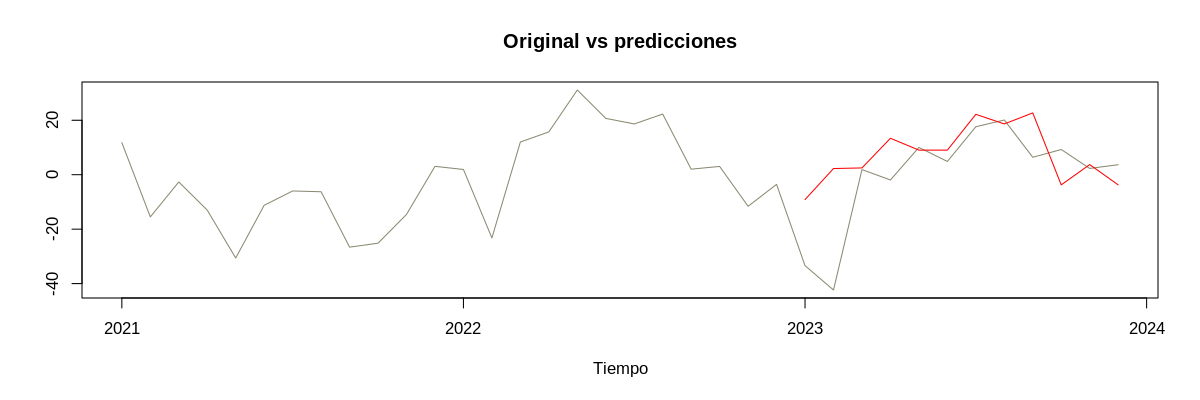

In [639]:
%%R -i predicciones -w 12 -h 4 --units in -r 100

plot(tail(leche$Volume,36), type = 'l',
     main = 'Original vs predicciones', col = '#8B8970',
     xaxt = 'n', xlab = 'Tiempo', ylab = '')
axis(side = 1, at = c(1,13,25,37), labels = 2021:2024)
lines(x = 25:36,y = predicciones, col = 'red')

### **Búsqueda de hiperparámetros**

A continuación se usará `grid search` para encontrar los mejores hiperparámetros para el árbol.

Los rezagos que se desean probar serán:

- Los rezagos secuenciales de 1 a 12
- Rezagos de 1, 6 y 12 meses
- Rezagos de 1, 3, 6, 9 y 12 meses
- Rezagos de 1 y 12 meses
- Rezagos de 6 y 12 meses

Es decir, en total probaremos con 16 combinaciones de rezagos distintas:

In [798]:
rezagos = [1,2,3,4,5,6,7,8,9,10,11,12,
           [1,6,12],
           [1,3,6,9,12],
           [1,12],
           [6,12]]

Y desearemos probar una profundidad máxima para el árbol de 30:

In [799]:
parámetros = {'max_depth': list(range(1,30))}

Y utilizaremos la métrica del error cuadrático medio (MSE) para decidir qué árbol es mejor

In [808]:
resultadosLeche = grid_search_forecaster(
                        forecaster         = arbolLeche,
                        y                  = trainLeche,
                        param_grid         = parámetros,
                        lags_grid          = rezagos,
                        steps              = 4,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(trainLeche)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 464.


lags grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/29 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 1}
  Backtesting metric: 228.76675280854002



In [806]:
resultadosLeche

,lags,params,mean_squared_error,max_depth
1,[1],{'max_depth': 2},196.093832,2
0,[1],{'max_depth': 1},208.427955,1
58,"[1, 2, 3]",{'max_depth': 1},208.515705,1
29,"[1, 2]",{'max_depth': 1},208.563575,1
87,"[1, 2, 3, 4]",{'max_depth': 1},208.584851,1
...,...,...,...,...
305,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",{'max_depth': 16},537.316699,16
306,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",{'max_depth': 17},537.316699,17
307,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",{'max_depth': 18},537.316699,18
317,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",{'max_depth': 28},537.316699,28


In [818]:
arbolLeche

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(max_depth=1, random_state=80) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2008-01-01 00:00:00'), Timestamp('2022-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 80, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2024-04-30 18:07:14 
Last fit date: 2024-04-30 19:20:56 
Skforecast version: 0.11.0 
Python version: 3.10.12 
Forecaster id: None 

In [823]:
arbolLeche.predict(steps = 24)

2023-01-01    3.282818
2023-02-01    3.282818
2023-03-01    3.282818
2023-04-01    3.282818
2023-05-01    3.282818
2023-06-01    3.282818
2023-07-01    3.282818
2023-08-01    3.282818
2023-09-01    3.282818
2023-10-01    3.282818
2023-11-01    3.282818
2023-12-01    3.282818
2024-01-01    3.282818
2024-02-01    3.282818
2024-03-01    3.282818
2024-04-01    3.282818
2024-05-01    3.282818
2024-06-01    3.282818
2024-07-01    3.282818
2024-08-01    3.282818
2024-09-01    3.282818
2024-10-01    3.282818
2024-11-01    3.282818
2024-12-01    3.282818
Freq: MS, Name: pred, dtype: float64